<h1>CS4618: Artificial Intelligence I</h1>
<h1>Dimensionality Reduction</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/bin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from math import pow, pi, sqrt
from numpy.random import rand
from scipy.special import gamma

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics.pairwise import euclidean_distances

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DataFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

# Class to draw 3D arrows
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly 2017
# Geron credits http://stackoverflow.com/questions/11140163
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<h1>The Curse of Dimensionality</h1>
<ul>
    <li>In some datasets, examples have thousands or even millions of features
        <ul>
            <li>E.g. datasets from astronomy</li>
        </ul>
    </li>
    <li>Is it better or worse to have more features?
        <ul>
            <li>Storage and processing costs increase</li>
            <li>Apart from efficiency, intuitively, more features is better
                <ul>
                    <li>E.g. describing houses more completely</li>
                </ul>
            </li>
            <li>But, counter-intuitively, that isn't true in general
                <ul>
                    <li>As the number of features grows, algorithms that use distance and density, will find it harder 
                        to find good solutions
                </ul>
            </li>
        </ul>
    </li>
    <li>To start our thinking about this:
        <ul>
            <li>Suppose there are two features, each with 10 different values. Then there are $10 \times 10 = 100$ different
                <em>possible</em> examples. Imagine that we've collected a dataset that contains 50 of these examples.
                Then the density is $50/100 = 0.5$
            </li>
            <li>Suppose there are three features, each with 10 different values. That means $10 \times 10 \times 10 = 1000$
                different <em>possible</em> examples. The density of our dataset (50 examples) is now $50/1000 = 0.05$
            </li>
            <li>With four such features, density becomes $50/10000 = 0.005$</li>
            <li>And so on</li>
        </ul>
        To keep the original level of density would require an exponentially growing dataset
    </li>
    <li>The problems that arise as the number of features grows have been called <b>the curse of dimensionality</b>
    </li>
</ul>

<h1>The Curse of Dimensionality</h1>
<ul>
    <li>Consider a sphere 'inscribed' inside a cube (i.e. it touches the sides): 
        <img style="float: right" src="images/11_inscribed.png" /></li>
    <li>Suppose the sides of the cube are of length 1 (to simplify calculations)</li>
    <li>What is the ratio of the volume of the sphere to volume of the cube?
        <ul>
            <li>Volume of the sphere $(4/3)\pi r^3 = 0.52$ (the radius, $r = 0.5$)</li>
            <li>Volume of the cube $1 \times 1 \times 1 = 1$</li>
            <li>Ratio $0.52/1 = 0.52$</li>
        </ul>
        So just over half the points fall within the sphere and less than half in the 'corners'
     </li>
     <li>But now increase the number of dimensions (features): a hypersphere inside a hypercube
         <ul>
             <li>Volume of hypersphere $\frac{\pi ^{\frac {n}{2}}}{\Gamma \left({\frac {n}{2}}+1\right)}r^{n}$</li>
             <li>Volume of hypercube is still 1</li>
             <li>As $n$ increases, ratio tends to 0</li>
         </ul>
         So it's as if most of the points are in the corners (relatively few in the sphere)!
     </li>
     <li>Intuition: as we consider ever more features, everyone becomes an extremist!
</ul>

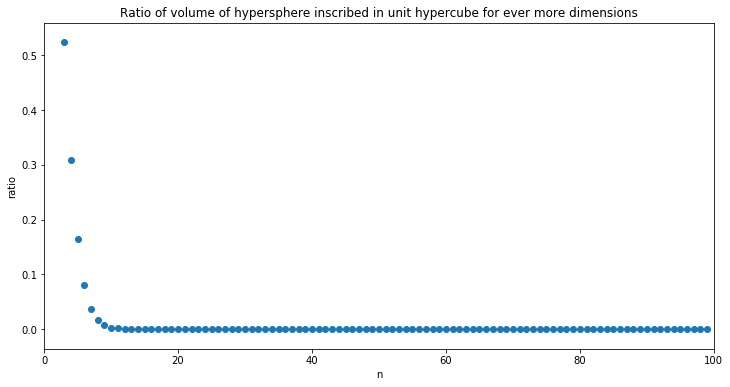

In [119]:
r = 0.5 # radius
n_range = range(3, 100)
    
# We don't need to divide the vol of the hypersphere by the vol of the hypercube because the latter is always 1
ratios = [pow(pi, n/2) * (r**n) / gamma(n/2 + 1) for n in n_range]
    
fig =plt.figure(figsize=(12,6))
plt.title("Ratio of volume of hypersphere inscribed in unit hypercube for ever more dimensions")
plt.scatter(n_range, ratios)
plt.xlabel("n")
plt.xlim(0, 100)
plt.ylabel("ratio")
plt.show()

<h1>The Curse of Dimensionality</h1>
<ul>
    <li>Here's another problem, this one concerning distances</li>
    <li>The code that follows (which you don't need to study) 
        <ul>
            <li>generates a random dataset where $m = 400$ and $n = 2$ and both features have values in $[0, 1)$
            </li>
            <li>computes the Euclidean distance between all pairs of examples</li>
            <li>finds $d_{\mathit{min}}$, the smallest of these distances</li>
            <li>finds $d_{\mathit{max}}$, the largest of the distances</li>
            <li>computes the ratio $\frac{d_{\mathit{max}}}{d_{\mathit{min}}}$</li>
        </ul>
    </li>
    <li>It then does this all again but with $n = 3, 4, 5,\ldots,500$</li>
    <li>Then it plots the ratios that it has computed ($y$-axis, but note its scale) against $n$ ($x$-axis)</li>
</ul>

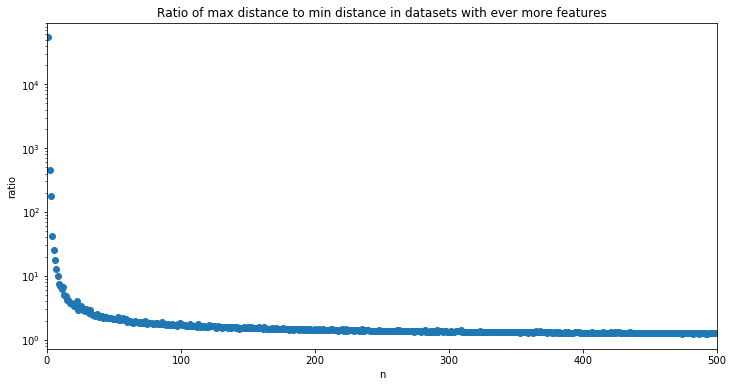

In [120]:
m = 400
n_range = range(1, 500)

ratios = []
for n in n_range:
    X = rand(m, n)
    dists = euclidean_distances(X)
    non_zero_dists = dists[dists > 0]
    ratios += [np.max(non_zero_dists) / (np.min(non_zero_dists))]
    
fig = plt.figure(figsize=(12,6))
plt.title("Ratio of max distance to min distance in datasets with ever more features")
plt.scatter(n_range, ratios)
plt.yscale('log')
plt.xlabel("n")
plt.xlim(0, 500)
plt.ylabel("ratio")
plt.show()

<ul>
    <li>As $n \rightarrow \infty$, $d_{\mathit{max}} \rightarrow d_{\mathit{min}}$, so their rato tends to 1</li>
</ul>

In [121]:
# Since it may not be clear from the graph, we'll show the last 5 of the ratios that it calculated
ratios[-5:]

[1.2603422534040309,
 1.275390689650084,
 1.2678245843413802,
 1.268209993661171,
 1.2630744863826584]

<ul>
    <li>We conclude (counter-intutively) that examples become equi-distant!</li>
    <li>This obviously undermines methods that depend on finding objects that are similar to each other, as we were
        doing in the previous lecture &mdash; with more features, the most similar object becomes more arbitrary!
    </li>
    <li>The problem extends to other distance/similarity measures, e.g. cosine similarity</li>
</ul>

<h1>Reducing the Number of Features</h1>
<ul>
    <li>Lots of methods available</li>
    <li>We look at <b>Principal Components Analysis</b> (PCA), roughly:
        <ul>
            <li>Creates new features based on the existing ones (linear combinations of the existing ones), one per existing
                feature
            </li>
            <li>Projects the dataset to a subset of the new features</li>
        </ul>
    </li>
    <li>A very informal presentation of PCA (without the maths)&hellip;
</ul>

<h1>Creating new features</h1>
<ul>
    <li>Suppose a dataset describes objects using just two features, e.g. weight and height</li> 
    <li>E.g.
        <table>
            <tr><th>Weight</th><th>Height</th></tr>
            <tr><td>1</td><td>1</td></tr>
            <tr><td>2</td><td>2</td></tr>
            <tr><td>0</td><td>2</td></tr>
        </table>
    </li>
    <li>Since there are only two features, we can plot &mdash; a 2D visualization:</li>
</ul>

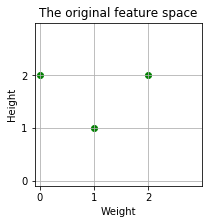

In [122]:
fig = plt.figure(figsize=(3,3))
plt.title("The original feature space")
ax = fig.gca()
ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
plt.scatter([1, 2, 0], [1, 2, 2], color = 'g')
plt.xlabel("Weight")
plt.xlim(-0.1, 3)
plt.ylabel("Height")
plt.ylim(-0.1, 3)
plt.grid()
plt.show()

<ul>
    <li>But the coordinate system we use (the axes) are arbitrary
    <li>We normally use a horizontal and a vertical axis</li>
    <li>But a different pair of axes would work just as well
        <ul>
            <li>E.g. we could draw one axis diagonally</li>
            <li>By convention, the other will be <b>perpendicular</b> (or 'orthogonal') to the first &mdash; 
                in other words, at right angles 
            </li>
            <li>But even then, we can decide where along the first axis to place it</li>
        </ul>
    </li>
</ul>

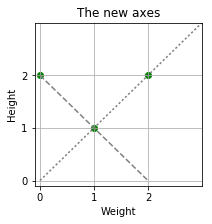

In [123]:
fig = plt.figure(figsize=(3,3))
plt.title("The new axes")
ax = fig.gca()
ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
plt.scatter([1, 2, 0], [1, 2, 2], color = 'g')
plt.plot([0, 4], [0, 4], linestyle = 'dotted', color = 'gray')
plt.plot([0, 2], [2, 0], linestyle = 'dashed', color = 'gray')
plt.xlabel("Weight")
plt.xlim(-0.1, 3)
plt.ylabel("Height")
plt.ylim(-0.1, 3)
plt.grid()
plt.show()

<ul>
    <li>But on this new 'graph paper', the coordinates of the points are now different
        <ul>
            <li>The first object used to be at $\Tuple{1, 1}$ but is now at $\Tuple{0, 0}$</li> 
            <li>The second object used to be at $\Tuple{2, 2}$ but is now at $\Tuple{\sqrt{2}, 0}$</li>
        </ul>
        <table>
            <tr><td>0</td><td>0</td></tr>
            <tr><td>$\sqrt{2}$</td><td>0</td></tr>
            <tr><td>0</td><td>$\sqrt{2}$</td></tr>
        </table>
    </li>
    <li>You can see this if we rotate the graph paper, so that the diagonal is horizontal:</li>
</ul>

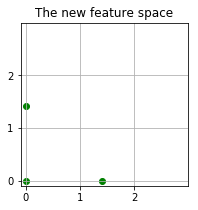

In [124]:
fig = plt.figure(figsize=(3,3))
plt.title("The new feature space")
ax = fig.gca()
ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
plt.scatter([0, sqrt(2), 0], [0, 0, sqrt(2)], color = 'g')
plt.xlim(-0.1, 3)
plt.ylim(-0.1, 3)
plt.grid()
plt.show()

<ul>
    <li>These new feature values convey exactly the same information as the originals &mdash; they're just on a 
        different coordinate system
    </li>
    <li>But there's an infinite choice of axes
        <ul>
            <li>For example, with just two features (in 2-dimensions), 
                <ul>
                    <li>the first axis can be horizontal (as it was originally), vertical or diagonal with all sorts 
                        of different slopes (steeper, shallower, etc.); 
                    </li>
                    </li>then the usual convention is that the second axis is perpendicular to the first</li>
                </ul>
            </li>
            <li>With more features, we have more choices: which to choose next and how to orient it</li>
        </ul>
    </li>
</ul>

<h1>Creating new features in PCA</h1>
<ul>
    <li>In PCA, 
        <ul>
            <li>The feature we transform next is always the one with the next greatest <b>variance</b> (spread)</li>
            <li>And the orientation of the axis is also based on covering the greatest amount of spread 
               (with the constraint that axes must be perpendicular to one another)
            </li>
        </ul>
    </li>
    <li><strong>Important:</strong> Making these decisions does require that the features be comparable
        <ul>
            <li>Hence, their values should be <em>standardized</em> first</li>
            <li>(Happily, scikit-learn's PCA class standardizes for us, so we don't even need the StandardScaler in
                our pipeline)
            </li>
        </ul>
    </li>
</ul>

<h1>Class exercise</h1>
<ul>
    <li>The plot contains examples described by two features, which you can assume have been standardized
        <img style="float: right" src="images/11_pca.png" />
    </li>
    <li>Draw onto this plot the new axes that PCA would choose</li>
</ul>

<h1>Example</h1>
<ul>
    <li>Code adapted from A. G&eacute;ron: <i>Hands-On Machine Learning with Scikit-Learn &amp; TensorFlow</i>, O'Reilly, 2017</li>
    <li>(Warning: It generates a random dataset and, for some random datasets, there may be division-by-zero errors. Just
        run it again!)
    </li>
</ul>

In [125]:
# Generate dataset

m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components = 3) 
pca.fit(X)
Xpc = pca.transform(X)

Xpc_inv = pca.inverse_transform(Xpc)

In [126]:
# Some variables

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]
x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

above = X[X[:, 2] > Xpc_inv[:, 2]]
below = X[X[:, 2] <= Xpc_inv[:, 2]]

In [127]:
def plot(ax):
    ax.plot(below[:, 0], below[:, 1], below[:, 2], "bo", alpha=0.5)
    ax.plot(above[:, 0], above[:, 1], above[:, 2], "bo")
    ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")

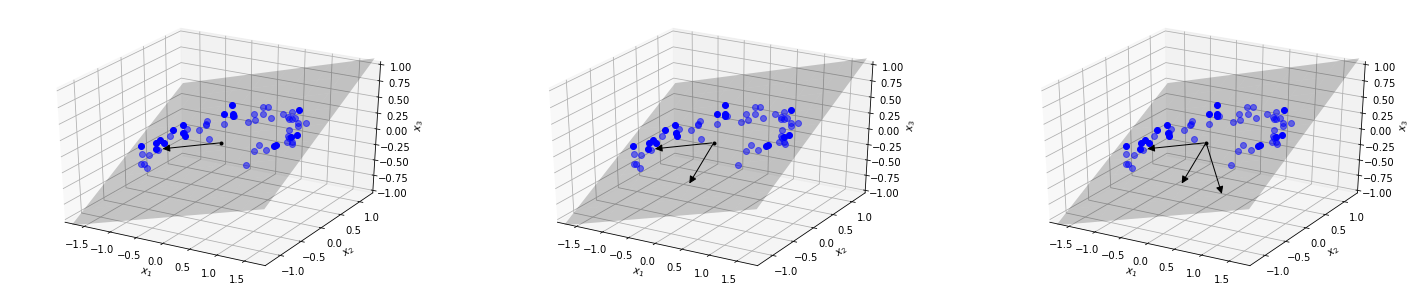

In [128]:
# Plot the dataset showing the three new axes
fig = plt.figure(figsize=(25, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot([0], [0], [0], "k.")
ax1.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
plot(ax1)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot([0], [0], [0], "k.")
ax2.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax2.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
plot(ax2)

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot([0], [0], [0], "k.")
ax3.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax3.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax3.add_artist(Arrow3D([0, C[2, 0]],[0, C[2, 1]],[0, C[2, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
plot(ax3)

plt.show()


<ul>
    <li>The unit vector that defines the <var>i</var><sup>th</sup> axis is called the <var>i</var><sup>th</sup>
        <b>principal component</b>
    </li>
    <li>But how does PCA find these axes?
        <ul>
            <li>By maths!</li>
            <li>(Look it up, if you're interested!)</li>
        </ul>
    </li>
    <li>At this stage, we've gained very little: we had $n$ features, we still have $n$ features</li>
</ul>

<h1>Project the dataset to a subset of the new features</h1>
<ul>
    <li>Examples in real-world datasets often lie close to a lower-dimensional subspace of the high-dimensional space
        <ul>
            <li>See the example above: the examples (which have $n = 3$ features) lie close to a lower-dimensional subspace,
                the 2D plane in grey
            </li>
        </ul>
    </li>
    <li>So, we can re-express our data ('project it') to just the first $k$ principal components, ignoring the others
        <ul>
            <li>We get a dataset with fewer features</li>
            <li>But, hopefully, very little loss of information</li>
        </ul>
    </li>
</ul>

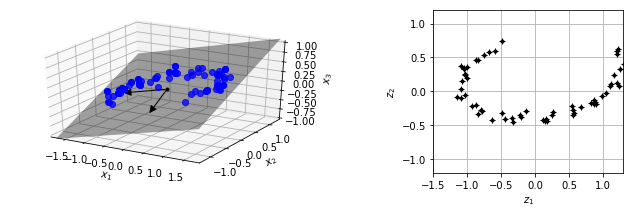

In [129]:
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121, projection='3d')
plot(ax1)
ax1.plot([0], [0], [0], "k.")
ax1.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax1.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
plot(ax1)
ax1.set_xlim(axes[0:2])
ax1.set_ylim(axes[2:4])
ax1.set_zlim(axes[4:6])

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(Xpc[:, 0], Xpc[:, 1], "k+")
ax2.plot(Xpc[:, 0], Xpc[:, 1], "k.")
ax2.set_xlabel("$z_1$")
ax2.set_ylabel("$z_2$")
ax2.axis([-1.5, 1.3, -1.2, 1.2])
ax2.grid(True)
plt.show()

<h1>PCA in scikit-learn</h1>
<ul>
    <li>Include it in your pipeline</li>
    <li>It automatically does standardization for you</li>
</ul>

In [130]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("datasets/dataset_corkA.csv")

# The features we want to select
features = ["flarea", "bdrms", "bthrms"]

# Create the pipeline
pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),
        ("pca", PCA(n_components=2))
    ])

# Run the pipeline
pipeline.fit(df)
X = pipeline.transform(df)

In [131]:
# Let's take a look at a few rows in X
X[:3]

array([[  3.68894389e+02,  -3.83770303e+00],
       [ -4.45064940e+01,  -3.02931319e-01],
       [ -3.05968933e+01,   1.05386436e-01]])

<h1>Explained Variance Ratio</h1>
<ul>
    <li>The <b>explained variance ratio</b> of each principal component tells us how much of the dataset's variance 
        lies along the axis of that principal component
    </li>
</ul>

In [132]:
pipeline.named_steps["pca"].explained_variance_ratio_

array([  9.99742385e-01,   1.54567956e-04])

<h1>How many principle components should we keep?</h1>
<ul>
    <li>If our goal is to <b>visualize</b> our dataset, then obviously 2 or 3</li>
    <li>Otherwise, there is no hard-and-fast answer:
        <ul>
            <li>depends on the dataset and what we are using it for</li>
        </ul>
    </li>
    <li>One option is to specify the proportion of variance that we wish to preserve
        <ul>
            <li>In scikit-learn, specify a number in $[0, 1]$ for the <code>n_components</code> parameter</li>
            <li>But, we still have to guess that number!</li>
        </ul>
    </li>
    <li>See the setting of hyperparameter values in CS4619</li>
</ul>

In [133]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("datasets/dataset_corkA.csv")

# The features we want to select
features = ["flarea", "bdrms", "bthrms"]

# Create the pipeline
pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),
        ("pca", PCA(n_components=0.9))
    ])

# Run the pipeline
pipeline.fit(df)
X = pipeline.transform(df)

In [134]:
# Let's take a look at a few rows in X
X[:3]

array([[ 368.8943895 ],
       [ -44.50649404],
       [ -30.59689329]])

<h1>Concluding remarks</h1>
<ul>
    <li>PCA is limited:
        <ul>
            <li>We use it for numeric-valued features</li>
            <li>Its new features are always linear combinations of the existing ones: in essence, we're
                fitting straight-line axes through the values
            </li>
        </ul>
    </li>
    <li>There are many techniques that work in a similar way but with more
        flexibility
        <ul>
            <li>E.g. techniques for non-numeric data such as Canonical Correspondence Anlaysis (CCA) for nominal-valued 
                data, and Singular Value Decomposition (SVD) (or Non-Negative Matrix Factorization, NMF) for
                text that uses the bag-of-words representation (next lecture)
            </li>
            <li>E.g. Kernel PCA to allow non-linear combinations
            </li>
        </ul>
    </li>
    <li>And 'manifold learning' methods, such as Isomap, Locally Linear Embedding, Multidimensional Scaling (MDS), 
        which work somewhat differently, but 
        work on some quite complex datasets
    </li>
</ul>